In [2]:
!pip install -q torch_geometric

# Optional dependencies:
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster \
torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [3]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.1.0+cu118


In [4]:
# Import all required modules:
import scipy.io as sc
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
import csv
import pandas as pd
import re
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GraphConv
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
import random
from sklearn.model_selection import KFold

#### Rewrite the .mat files into a useable format:
Then save the data into useable variables

In [12]:
%cd ./Documents/Git_coding_respositories/ECE_Project_2/Deep-learn

[WinError 3] The system cannot find the path specified: './Documents/Git_coding_respositories/ECE_Project_2/Deep-learn'
C:\Users\Adam\Documents\Git_coding_respositories\ECE_Project_2\Deep-learn


In [13]:
%pwd

'C:\\Users\\Adam\\Documents\\Git_coding_respositories\\ECE_Project_2\\Deep-learn'

In [15]:
# Make directory if it doesn't exist
if os.path.exists("./data_processed/BP") == False:
    os.makedirs("./data_processed/BP")
    os.makedirs("./data_processed/NC")
    os.makedirs("./data_processed/All")

file_root = "./data"
file_root_data_path = os.listdir(file_root)
bp = []

for file in file_root_data_path:
    mat1 = sc.loadmat("{}/{}".format(file_root, file))
    mat1 = np.array(mat1["C"])
    # Process each file type into separate folders in case needed
    if re.search("BP", file):
        with open("./data_processed/BP/{}.txt".format(os.path.splitext(file)[0]), "w") as f:
            csv.writer(f, delimiter=',').writerows(mat1)
    elif re.search("NC", file):
        with open("./data_processed/NC/{}.txt".format(os.path.splitext(file)[0]), "w") as f:
            csv.writer(f, delimiter=',').writerows(mat1)
    # Saved all files into an all folder
    with open("./data_processed/All/{}.txt".format(os.path.splitext(file)[0]), "w") as f:
        csv.writer(f, delimiter=',').writerows(mat1)
        
# Load the adjacency matrices from the text files as numpy arrays:
import pandas as pd

bp_root = "./data_processed/BP"
bp_root_path = os.listdir(bp_root)
nc_root = "./data_processed/NC"
nc_root_path = os.listdir(nc_root)
all_files_root = "./data_processed/All"
all_files_root_path = os.listdir(all_files_root)
bp = []
nc = []
all_files = []

for file in bp_root_path:
    mat1 = pd.read_csv("{}/{}".format(bp_root,file), header=None).to_numpy()
    bp.append(mat1)

for file in nc_root_path:
    mat1 = pd.read_csv("{}/{}".format(nc_root,file), header=None).to_numpy()
    nc.append(mat1)

labels = []

for file in all_files_root_path:
    mat1 = pd.read_csv("{}/{}".format(all_files_root,file), header=None).to_numpy()
    if re.search("BP", file):
        labels.append(1)
    else:
        labels.append(0)
    all_files.append(mat1)

### Data Setup:
Rewrite .mat files into a usable format, Load those files into variables:

In [17]:
# Convert the adjacency matrices to dataframes that can be used in pytorch:
# Function to calculate the edge_matrix
def calc_edge_matrix(adjacency_matrices):
        num_nodes = adjacency_matrices[0].shape[0]
        edge_index = []
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                weight = all_files[i][j]
                if weight.any != 0:
                    edge_index.append([i, j])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        return edge_index

# Prepare Data for PyTorch
def prepare_data(adjacency_matrices, labels):
    graph_data = []
    for adj_matrix, label in zip(adjacency_matrices, labels):
        edge_index = calc_edge_matrix(adjacency_matrices)
        x = torch.tensor((adj_matrix), dtype=torch.float)  # Features (e.g., all ones)
        y = torch.tensor([label], dtype=torch.long)
        num_classes = 2
        num_features = len(bp[0])
        num_nodes = len(bp[0])
        num_edges = 3486
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_features = num_features, num_nodes = num_nodes, num_edges = num_edges)
        graph_data.append(data)
    return graph_data
# Create a dataset from the prepared data
graph_data = prepare_data(all_files, labels)

# Perform the K-fold cross-validation splits:
k = 5 # number of spits to perform, must be 5 for 80/20
kf = KFold(n_splits=k, shuffle=True, random_state=499)
random.seed(412)
shuffled_graph_data = random.sample(graph_data, len(graph_data))
train_mask = []
test_mask = []

# Generate the train and test mask for selecting the data:
for i, (train_index, test_index) in enumerate(kf.split(shuffled_graph_data)):
    train_mask.append(train_index)
    test_mask.append(test_index)

train_data = [[] for _ in range(5)]
for i in range(len(train_mask)):
    for j in train_mask[i]:
        train_data[i].append(shuffled_graph_data[j])

test_data = [[] for _ in range(5)]
for i in range(len(test_mask)):
    for j in test_mask[i]:
        test_data[i].append(shuffled_graph_data[j])

train_loader = DataLoader(train_data, batch_size=7, shuffle=False)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

c:\Users\Adam\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
# Grab information about the dataset:
print()
print(f'Dataset: {graph_data[0]}:')
print('====================')
print(f'Number of graphs: {len(graph_data)}')
print(f'Number of features: {graph_data[0].num_features}')
print(f'Number of classes: {graph_data[0].num_classes}')

data = graph_data[0]

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Dataset: Data(x=[84, 84], edge_index=[2, 3486], y=[1], num_classes=2, num_features=84, num_nodes=84, num_edges=3486):
Number of graphs: 97
Number of features: 84
Number of classes: 2

Data(x=[84, 84], edge_index=[2, 3486], y=[1], num_classes=2, num_features=84, num_nodes=84, num_edges=3486)
Number of nodes: 84
Number of edges: 3486
Average node degree: 41.50


### Build and Instantiate the GNN

In [21]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, output_channels):
        super(GCN, self).__init__()
        torch.manual_seed(23145)
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, output_channels)
        self.lin = Linear(output_channels, graph_data[0].num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64, output_channels = 64)
print(model)

# Define train and test functions
def train(loader, k):
    model.train()

    for data in loader.dataset[k]:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader, k):
    model.eval()

    correct = 0
    for data in loader.dataset[k]:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset[k]) # Derive ratio of correct predictions.

GCN(
  (conv1): GCNConv(-1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Train and then evaluate the GNN:

==================== K-fold data split 1 ====================
Epoch: 000, Train Acc: 59.7403%, Test Acc: 30.0000%
Epoch: 001, Train Acc: 59.7403%, Test Acc: 30.0000%
Epoch: 002, Train Acc: 55.8442%, Test Acc: 65.0000%
Epoch: 003, Train Acc: 66.2338%, Test Acc: 30.0000%
Epoch: 004, Train Acc: 81.8182%, Test Acc: 55.0000%
Epoch: 005, Train Acc: 77.9221%, Test Acc: 40.0000%
Epoch: 006, Train Acc: 76.6234%, Test Acc: 45.0000%
Epoch: 007, Train Acc: 71.4286%, Test Acc: 40.0000%
Epoch: 008, Train Acc: 70.1299%, Test Acc: 30.0000%
Epoch: 009, Train Acc: 75.3247%, Test Acc: 45.0000%
Epoch: 010, Train Acc: 68.8312%, Test Acc: 35.0000%
Epoch: 011, Train Acc: 72.7273%, Test Acc: 35.0000%
Epoch: 012, Train Acc: 81.8182%, Test Acc: 45.0000%
Epoch: 013, Train Acc: 89.6104%, Test Acc: 60.0000%
Epoch: 014, Train Acc: 93.5065%, Test Acc: 50.0000%
Epoch: 015, Train Acc: 89.6104%, Test Acc: 50.0000%
Epoch: 016, Train Acc: 92.2078%, Test Acc: 50.0000%
Epoch: 017, Train Acc: 75.3247%, Test Acc: 45.0000%
Ep

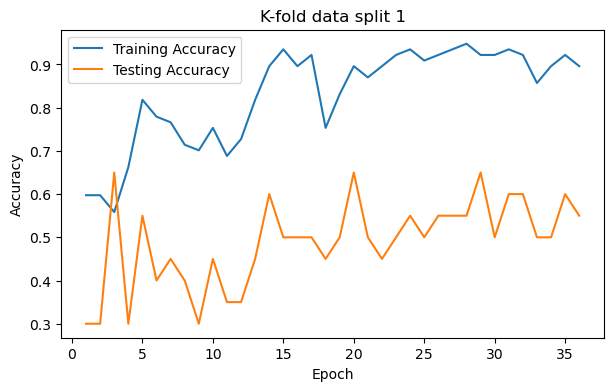



==================== K-fold data split 2 ====================
Epoch: 000, Train Acc: 55.8442%, Test Acc: 50.0000%
Epoch: 001, Train Acc: 79.2208%, Test Acc: 50.0000%
Epoch: 002, Train Acc: 77.9221%, Test Acc: 30.0000%
Epoch: 003, Train Acc: 55.8442%, Test Acc: 55.0000%
Epoch: 004, Train Acc: 77.9221%, Test Acc: 40.0000%
Epoch: 005, Train Acc: 80.5195%, Test Acc: 55.0000%
Epoch: 006, Train Acc: 84.4156%, Test Acc: 35.0000%
Epoch: 007, Train Acc: 84.4156%, Test Acc: 55.0000%
Epoch: 008, Train Acc: 80.5195%, Test Acc: 45.0000%
Epoch: 009, Train Acc: 77.9221%, Test Acc: 40.0000%
Epoch: 010, Train Acc: 85.7143%, Test Acc: 45.0000%
Epoch: 011, Train Acc: 84.4156%, Test Acc: 45.0000%
Epoch: 012, Train Acc: 84.4156%, Test Acc: 45.0000%
Epoch: 013, Train Acc: 84.4156%, Test Acc: 40.0000%
Epoch: 014, Train Acc: 87.0130%, Test Acc: 50.0000%
Epoch: 015, Train Acc: 87.0130%, Test Acc: 50.0000%
Epoch: 016, Train Acc: 90.9091%, Test Acc: 50.0000%
Epoch: 017, Train Acc: 84.4156%, Test Acc: 60.0000%


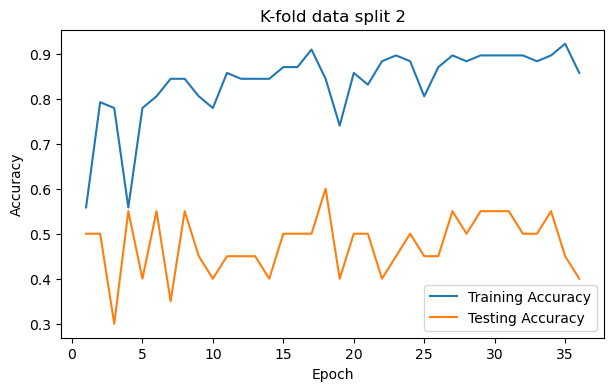



==================== K-fold data split 3 ====================
Epoch: 000, Train Acc: 48.7179%, Test Acc: 73.6842%
Epoch: 001, Train Acc: 55.1282%, Test Acc: 73.6842%
Epoch: 002, Train Acc: 65.3846%, Test Acc: 68.4211%
Epoch: 003, Train Acc: 55.1282%, Test Acc: 73.6842%
Epoch: 004, Train Acc: 67.9487%, Test Acc: 78.9474%
Epoch: 005, Train Acc: 85.8974%, Test Acc: 57.8947%
Epoch: 006, Train Acc: 84.6154%, Test Acc: 57.8947%
Epoch: 007, Train Acc: 78.2051%, Test Acc: 57.8947%
Epoch: 008, Train Acc: 83.3333%, Test Acc: 78.9474%
Epoch: 009, Train Acc: 85.8974%, Test Acc: 52.6316%
Epoch: 010, Train Acc: 76.9231%, Test Acc: 63.1579%
Epoch: 011, Train Acc: 89.7436%, Test Acc: 89.4737%
Epoch: 012, Train Acc: 91.0256%, Test Acc: 63.1579%
Epoch: 013, Train Acc: 88.4615%, Test Acc: 68.4211%
Epoch: 014, Train Acc: 87.1795%, Test Acc: 84.2105%
Epoch: 015, Train Acc: 91.0256%, Test Acc: 68.4211%
Epoch: 016, Train Acc: 91.0256%, Test Acc: 68.4211%
Epoch: 017, Train Acc: 93.5897%, Test Acc: 73.6842%


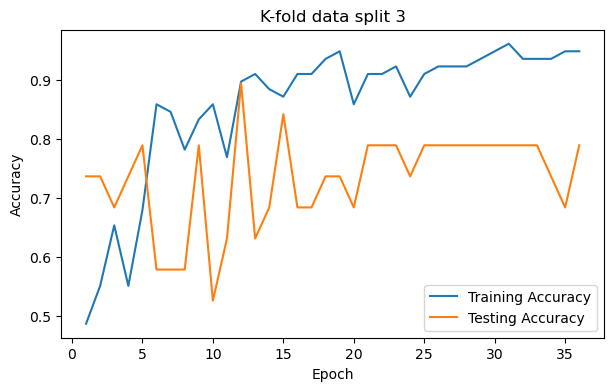



==================== K-fold data split 4 ====================
Epoch: 000, Train Acc: 53.8462%, Test Acc: 63.1579%
Epoch: 001, Train Acc: 51.2821%, Test Acc: 63.1579%


In [23]:
master_train_acc = []
master_test_acc = []

#=========== Loop variables ========================
counter = k # Number of k-fold splits being performed
num_epochs = 35

# Model variables
hidden_channels = 64
output_channels = 64
#===================================================
for i in range(counter):
    train_acc_history = []
    test_acc_history = []
    model = GCN(hidden_channels, output_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    if i == 0:
        print(f"==================== K-fold data split {i+1} ====================")
    else:
        print(f"\n\n==================== K-fold data split {i+1} ====================")
    for epoch in range(num_epochs+1):
        train(train_loader, i)
        train_acc = test(train_loader, i)
        train_acc_history.append(train_acc)
        test_acc = test(test_loader, i)
        test_acc_history.append(test_acc)
        print(f'Epoch: {epoch:03d}, Train Acc: {100*train_acc:.4f}%, Test Acc: {100*test_acc:.4f}%')

    master_train_acc.append(train_acc)
    master_test_acc.append(test_acc)

    plt.figure(figsize=(7,4))
    plt.title(f"K-fold data split {i+1}")
    plt.plot(range(1, num_epochs+2), train_acc_history, label='Training Accuracy')
    plt.plot(range(1, num_epochs+2), test_acc_history, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

print(f"The overall average training accuracy is: {np.mean(master_train_acc):.4f}")
print(f"The overall average testing accuracy is: {np.mean(master_test_acc):.4f}")


#### Perform Light probability analysis to determine if the model was just getting lucky:

In [ ]:
master_train_acc = []
master_test_acc = []

#=========== Loop variables ========================
counter = k # Number of k-fold splits being performed
num_epochs = 35

# Model variables
hidden_channels = 64
output_channels = 64
#===================================================
for i in range(counter):
        train_acc_history = []
        test_acc_history = []
        model = GCN(hidden_channels, output_channels)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()
        if i == 0:
                print(f"==================== K-fold data split {i+1} ====================")
        else:
                print(f"\n\n==================== K-fold data split {i+1} ====================")
        for epoch in range(num_epochs+1):
                train(train_loader, i)
                train_acc = test(train_loader, i)
                train_acc_history.append(train_acc)
                test_acc = test(test_loader, i)
                test_acc_history.append(test_acc)
                print(f'Epoch: {epoch:03d}, Train Acc: {100*train_acc:.4f}%, Test Acc: {100*test_acc:.4f}%')

master_train_acc.append(train_acc)
master_test_acc.append(test_acc)

plt.figure(figsize=(7,4))
plt.title(f"K-fold data split {i+1}")
plt.plot(range(1, num_epochs+2), train_acc_history, label='Training Accuracy')
plt.plot(range(1, num_epochs+2), test_acc_history, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"The overall average training accuracy is: {np.mean(master_train_acc):.4f}")
print(f"The overall average testing accuracy is: {np.mean(master_test_acc):.4f}")


List of all labels in the test set: [[1], [1], [0], [0], [0], [1], [1], [0], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [1], [0]]
The random chance that the model predicts the ones class: 0.5
The random chance that the model precicts the zeros class: 0.5
List of all labels in the test set: [[1], [1], [0], [0], [0], [1], [1], [0], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [1], [0], [1], [1], [0], [1], [0], [1], [1], [1], [0], [1], [0], [1], [0], [0], [0], [1], [0], [0], [1], [0]]
The random chance that the model predicts the ones class: 0.5
The random chance that the model precicts the zeros class: 0.5
List of all labels in the test set: [[1], [1], [0], [0], [0], [1], [1], [0], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [1], [0], [1], [1], [0], [1], [0], [1], [1], [1], [0], [1], [0], [1], [0], [0], [0], [1], [0], [0], [1], [0], [1], [0], [0], [0], [1], [1], [1], [0], [0], [1], [1], [1], [1], [0], [1], [0], [0], [0], [1]]
The random chance that the model predicts th

Basic probability analysis: Is the model simply getting lucky with random guesses?


In [2]:
# Probability analysis -- are my results entirely from chance?
y = []
ones = 0
zeros = 0
for i in range(len(test_data)):
        for item in test_data[i]:
                y.append(item.y.tolist())
                if item.y == 1:
                        ones += 1
                else:
                        zeros += 1
        print(f"For dataset {i+1}:")
        print(f"The random chance that the model predicts the ones class: {ones / len(y)}")
        print(f"The random chance that the model precicts the zeros class: {zeros/ len(y)}")
        print("============================================================")

NameError: name 'test_data' is not defined